# Tracking iterative executions

One of the main primitives in our framework is `Pipeline`, which runs the same list of procedures over and over. It is essential to have a tool to notify the user on its progress; for situations where plain `tqdm` bar is just not enough we've developed `Notifier` and `Monitor` classes that provide fine-grained updates on the state of iterative flow. This notebooks shows how to:

- track utilization for a wide variety of resources (cpu, gpu, memory, etc)
- create an iteration-wise notifications for values of pipeline variables and other entities
- plot graphs (for example, loss values) on the fly

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from time import sleep
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
from tqdm import tqdm_notebook, tqdm

sys.path.append('../..')
from batchflow import Pipeline, Dataset, I, W, V, B, F, set_gpus
from batchflow import Notifier, notifier, CPUMonitor, Monitor

# Set GPU
set_gpus(n=1);

`CUDA_VISIBLE_DEVICES` set to "6"


In [2]:
DEVICE = torch.device('cuda:0')
torch.ones((1, 1, 1), device=DEVICE)

BAR = 't' # can be changed to 'n' to use Jupyter Notebook progress bar everywhere

## Notifier

In the simplest case we use `Notifier` as a drop-in replacement for `tqdm` progress bar, and the behaviour remains the same. Positional argument `bar` tells which progress bar implementation to use:

- `t` stands for plain text `tqdm`
- `n` allows to make use of modern `tqdm_notebook` graphics
- `a` automatically changes from text-based to GUI, depending on the environment it is being used

In [3]:
for item in Notifier(BAR)(range(25)):
    sleep(0.1)

100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.88it/s]


As some of the loops are running hundreds of iterations per second, we should take special care of speed of updating: as we can see, the overhead is negligeable for both text and graphical versions of the `Notifier`:

In [4]:
%time for item in Notifier('t')(range(100000)): pass
%time for item in tqdm(range(100000)): pass

100%|███████████████████████████████| 100000/100000 [00:00<00:00, 371638.77it/s]
CPU times: user 269 ms, sys: 13.5 ms, total: 283 ms
Wall time: 281 ms


100%|██████████| 100000/100000 [00:00<00:00, 2621489.15it/s]

CPU times: user 40.9 ms, sys: 1.09 ms, total: 41.9 ms
Wall time: 41.3 ms


In [5]:
%time for item in Notifier('n')(range(100000)): pass
%time for item in tqdm_notebook(range(100000)): pass

0it [00:00, ?it/s]

  0%|                                                                                                         …

CPU times: user 434 ms, sys: 13.6 ms, total: 448 ms
Wall time: 441 ms


  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 52.7 ms, sys: 0 ns, total: 52.7 ms
Wall time: 51.1 ms


Just as there are many interfaces for vanilla `tqdm`, we provide a number of ways for updating the progress bar, and all of them work for iterables with either known or unknown lengths.

In the simplest case, we can use the instance as a wrapper. `notifier` simplifies that even further:

In [6]:
ntf = Notifier(BAR)
for item in ntf(range(25)):
    sleep(0.1)

ntf = Notifier(BAR)
for item in ntf(iter(range(25))):
    sleep(0.1)
    

# `notifier` is a wrapper for iterables
for item in notifier(range(25), bar=BAR):
    sleep(0.1)
    
for item in notifier(iter(range(25)), bar=BAR):
    sleep(0.1)

100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.86it/s]
25it [00:02,  9.88it/s]
100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.85it/s]
25it [00:02,  9.89it/s]


We can also update instances manually, exactly when needed: this way, you will need to `close` the instance by hand as well.

In [7]:
ntf = Notifier(BAR, total=25)
for _ in range(25):
    sleep(0.1)
    ntf.update()
ntf.close()

ntf = Notifier(BAR)
for _ in range(25):
    sleep(0.1)
    ntf.update()
ntf.close()

100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.86it/s]
25it [00:02,  9.87it/s]


You can use `Notifier` as context manager, so it handles the `close` for you:

In [8]:
with Notifier(BAR, total=25) as ntf:
    for _ in range(25):
        sleep(0.1)
        ntf.update()
        
with Notifier(BAR) as ntf:
    for _ in range(25):
        sleep(0.1)
        ntf.update()

100%|███████████████████████████████████████████| 25/25 [00:02<00:00,  9.86it/s]
25it [00:02,  9.88it/s]


## Monitors

We will return to `Notifier` and its other arguments in just a second; for now, let's look at other feature: `Monitor`s. As we intent to use our pipelines to work with enormous neural networks on gigantic datasets, we must finely control all of our resources: CPU, RAM, GPU load, etc. `Monitor`s provide us tools to visualize resource utilization over a period of time: mere addition of a special context manager allows us to look into CPU usage in details:

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.15it/s]


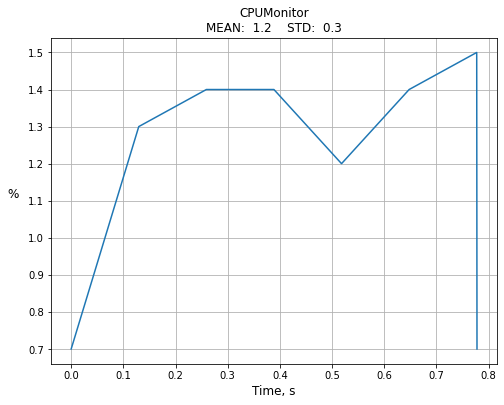

In [9]:
with CPUMonitor(frequency=0.1) as cpu_monitor:
    for _ in notifier(range(10), bar=BAR):
        _ = np.random.random((1000, 10000))
        
cpu_monitor.visualize()

Under the hood `Monitor` creates a separate process, that checks the state of a resource every `frequency` seconds and can fetch collected data on demand.

There are a number of resources that can be tracked:
- CPU utilization (`cpu`)
- RAM used by the current process (`uss`)
- total RAM used on the machine (`memory`)
- GPU utilization (`gpu`)
- GPU memory used (`gpu_memory`)

For convenience we also provide context manager to track multiple entities at once:

100%|███████████████████████████████████████████| 42/42 [00:07<00:00,  5.88it/s]


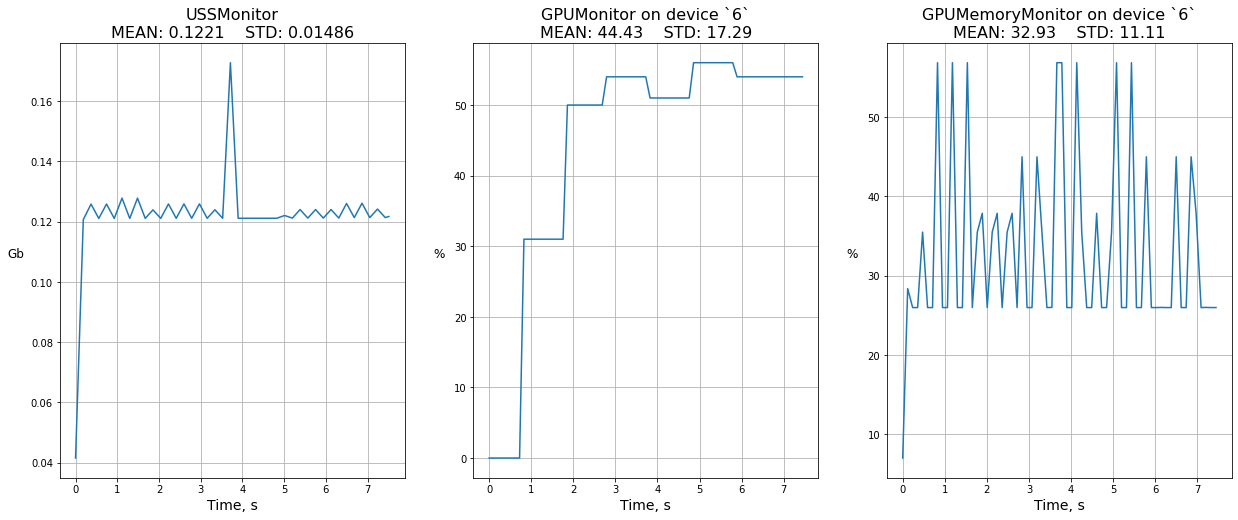

In [10]:
with Monitor(['uss', 'gpu', 'gpu_memory'], frequency=0.1) as multi_monitor:
    for _ in notifier(range(42), bar=BAR):
        cpu_data = np.random.random((1000, 10000))

        gpu_data = torch.ones((256, 512, 2096), device=DEVICE)
        gpu_op = torch.mvlgamma(torch.erfinv(gpu_data), 1)         # intense operation
        torch.cuda.empty_cache()
        
multi_monitor.visualize()

This feature is immensely helpful during both research and deploy stages, so we included it in the `Notifier` itself: it has never been so easy to always keep track of all the resources!

Note that monitors connected to an instance of `Notifier` provide information on the resource usage not only every `frequency` seconds, but also at the end of each iteration.

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 552.21it/s]


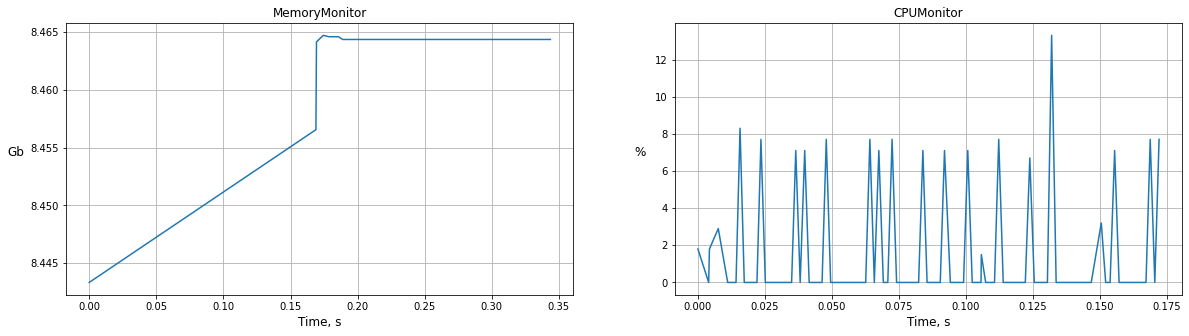

In [11]:
ntf = Notifier(BAR, monitors=['memory', 'cpu'])

for _ in ntf(range(100)):
    _ = np.random.random((1000, 100))

ntf.visualize()

## Pipeline

As was already mentioned, one of the prime purposes of our notification system is to be used in tandem with `Pipeline`. We create a rather simple one with following variables:

- list `loss_history` that is updated at each iteration with a new value
- 2D array `image` that is randomly generated at each iteration

In [12]:
pipeline = (
    Pipeline()
    .init_variable('loss_history', [])
    .init_variable('image')

    .update(V('loss_history', mode='a'), 100 * 2 ** (-I()))
    .update(V('image'), F(np.random.random)((30, 30)))
    .call(sleep, 0.2)
) << Dataset(10)

## Vanilla pipeline
The easiest way to track progress is to supply `notifier` argument to the `run` method. It works with:

- an instance of `Notifier`
- string (`t`, `n`, `a`) would be used as positional argument for `Notifier` creation in the bowels of `Pipeline`
- dictionary with parameters of `Notifier` initialization

In [13]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier='t')

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.93it/s]


## Track pipeline variables

We can use notifier to track values of pipeline variables at each iteration: conveniently, we use the same `monitor` argument:

fancy research: 100%|████████████████| 10/10 [00:02<00:00,  4.64it/s, loss_history=0.0977]


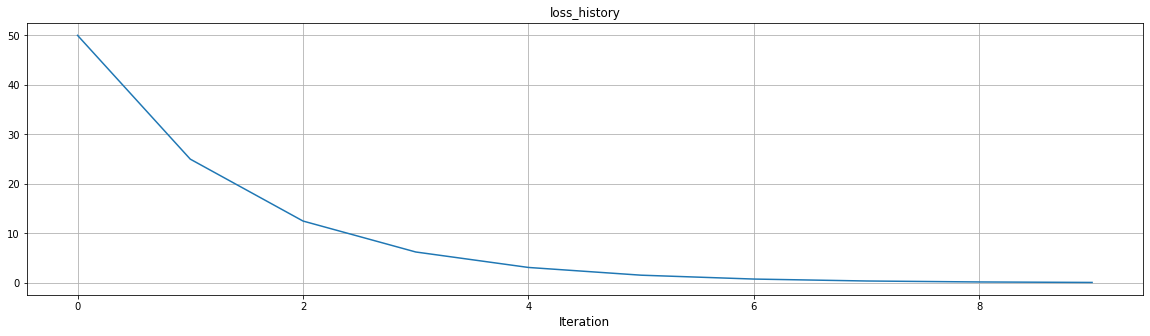

In [14]:
pipeline.reset('all')
ntf = Notifier(BAR, monitors='loss_history', desc='fancy research')
_ = pipeline.run(1, n_iters=10, notifier=ntf)

ntf.visualize()

Obviously, we can use the same resource monitors, as before, by passing additional items to `monitors`. There is also `file` argument, that allows us to log the progress to an external storage:

100%|██████████████████████████████████████████| 50/50 [00:10<00:00,  4.88it/s, loss_history=0.0000]


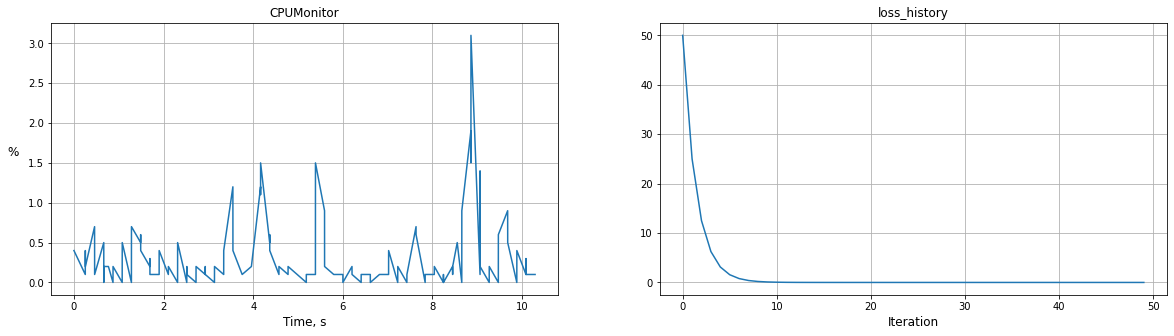

In [15]:
pipeline.reset('all')
ntf = Notifier(BAR, monitors=['cpu', 'loss_history'], log_file='notifications.txt')
_ = pipeline.run(1, n_iters=50, notifier=ntf)

ntf.visualize()

In [16]:
!head notifications.txt -n 13
!rm notifications.txt

2021-12-29  23:43:20     Iteration     0;    loss_history=50.0000
2021-12-29  23:43:20     Iteration     1;    loss_history=25.0000
2021-12-29  23:43:21     Iteration     2;    loss_history=12.5000
2021-12-29  23:43:21     Iteration     3;    loss_history=6.2500
2021-12-29  23:43:21     Iteration     4;    loss_history=3.1250
2021-12-29  23:43:21     Iteration     5;    loss_history=1.5625
2021-12-29  23:43:21     Iteration     6;    loss_history=0.7812
2021-12-29  23:43:22     Iteration     7;    loss_history=0.3906
2021-12-29  23:43:22     Iteration     8;    loss_history=0.1953
2021-12-29  23:43:22     Iteration     9;    loss_history=0.0977
2021-12-29  23:43:22     Iteration    10;    loss_history=0.0488
2021-12-29  23:43:22     Iteration    11;    loss_history=0.0244
2021-12-29  23:43:23     Iteration    12;    loss_history=0.0122


## Live plots

One of the distinct features of `Notifier` is its ability of plotting data on the fly: to do so, we must supply `graphs` argument. Its semantics are exactly the same as those of `monitors` parameter.

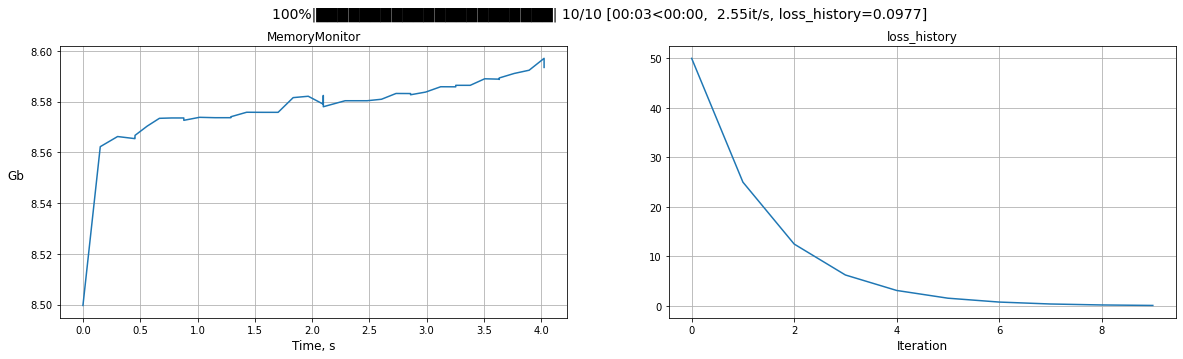

In [17]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=10, notifier=Notifier('n', graphs=['memory', 'loss_history']))

It can work with images also. As the rendering of plots might take some time, we want to do so once every 10 iterations and achieve so by using `frequency` parameter:

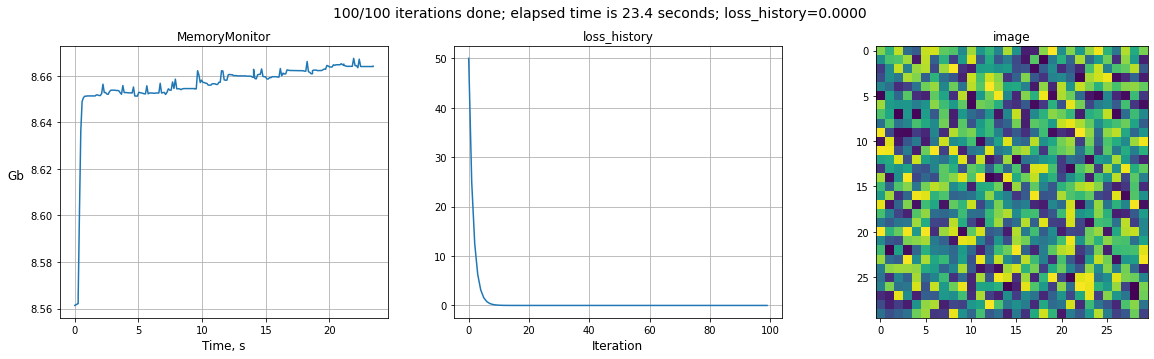

In [18]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=100, notifier=Notifier(None, graphs=['memory', 'loss_history', 'image'], frequency=10))

If you want to show live graphs of your resources, you don't have to use `Pipeline`. `Notifier` can also track any iterable container and display it in the description or on graph:

In [19]:
container = []
for i in notifier(range(15), bar=BAR, monitors=['cpu', container]):
    container.append(i**3)

100%|███████████████████████████████████| 15/15 [00:00<00:00, 651.72it/s, <unknown_container>=2,744]


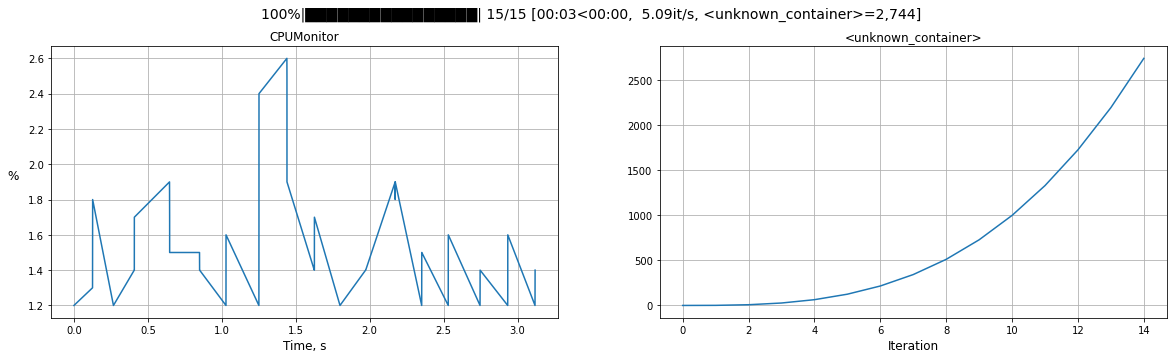

In [20]:
container = []
for i in notifier(range(15), bar=BAR, graphs=['cpu', container]):
    container.append(i**3)

## Advanced usage of Notifier

Different people prefer different types of notifications: for some modest `print` is enough, while some build complex systems to bring notifications to their mobile devices. Our `Notifier` gives you fine control on how the data is shown so you can tune it for yourself.

Previously, we passed strings as `monitor`/`graphs` parameters to identify, which exactly pipeline variable or resource should be tracked. Under the hood, each of them is parsed to a dictionary with parameters:

- `source` determines the data generator
- `name` used for plot titles and near bar text descriptions
- `format` used to create fully custom bar text descriptions
- `plot_function` can be called for custom plotting mechanism

We can leverage those parameters make all the plots to our liking:

In [21]:
def custom_plotter(ax=None, container=None, **kwargs):
    """ Zero-out center area of the image, change plot parameters. """
    container['data'][10:20, 10:20] = 0
    
    ax.imshow(container['data'])
    ax.set_title(container['name'], fontsize=18)
    
    ax.set_xlabel('axis one', fontsize=18)
    ax.set_ylabel('axis two', fontsize=18)

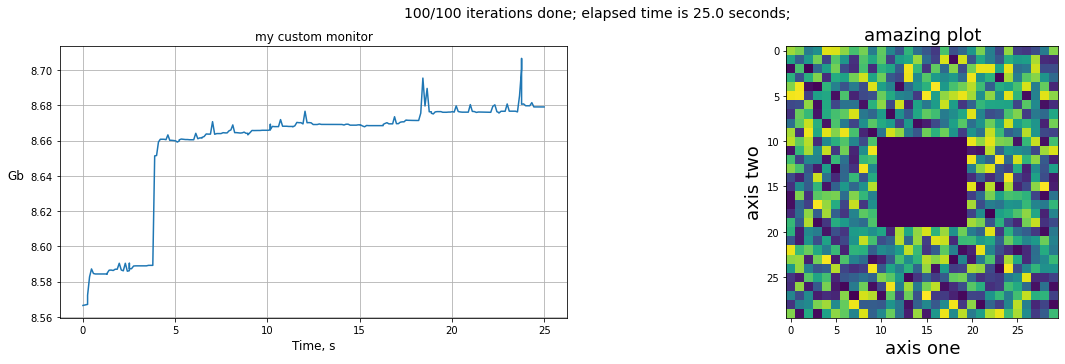

In [22]:
pipeline.reset('all')
_ = pipeline.run(1, n_iters=100,
                 notifier=Notifier(None,
                                   graphs=[{'source': 'memory',
                                            'name': 'my custom monitor'},
                                           {'source': 'image',
                                            'name': 'amazing plot',
                                            'plot_function': custom_plotter}],
                                   frequency=5))

You can use the same syntax to customize printed descriptions for tracked containers:

In [23]:
container = []
for i in notifier(range(15), bar=BAR, monitors={'source': container, 'format': 'descriptive_description={0}'}):
    container.append(i**3)

100%|█████████████████████| 15/15 [00:00<00:00, 1444.92it/s, descriptive_description=2744]
